# **SENTIMENT ANALYSIS FOR ELECTION USING TWITTER DATA**


#Importing libs

In [1]:
import tweepy as tw
import pandas as pd
from wordcloud import WordCloud
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import seaborn as sns
from sklearn.utils import Bunch
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#Reading Data

In [2]:
tweet_df = pd.read_csv('tweets_election.csv',index_col=0)
tweet_df.head(20)

,geo,text,user,location,Subject,state
3,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey
6,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas
11,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts
15,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey
16,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota
18,NaN,'A vote for Donald Trump is a vote against the...,TMScarletFire,"Salem, MA",Donald Trump,Massachusetts
25,NaN,There is no greater supporter of Donald Trump...,mwamsley5,Ohio,Donald Trump,Ohio
29,NaN,The same people who are outraged at AOC for s...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota
30,NaN,Donald Trump is on track to become the worst ...,XchargerFan619,"San Diego, CA",Donald Trump,California
38,NaN,"It is Friday, October 30, 2020. One citizen, I...",eachlifeinplace,Iowa,Donald Trump,Iowa


#Functions

In [72]:
import re
def clean_tweets(text):
  text = re.sub("RT @[\w]*:","",text)
  text = re.sub("@[\w]*","",text)
  text = re.sub("https?://[A-Za-z0-9./]*","",text)
  text = re.sub("\n","",text)
  return text
def wordcloud(data,title):
    text = str(data.text)
    wc = WordCloud(max_font_size=100,max_words=500,scale=10,relative_scaling=0.6,background_color='white').generate(text)
    plt.figure(figsize=(15,10))
    plt.title(title,{'fontsize':30,'family':'serif'})
    plt.axis('off')
    plt.imshow(wc)
def undersampling():
    print('Original dataset', sorted(Counter(target).items()))
    from imblearn.under_sampling import RandomUnderSampler
    ros = RandomUnderSampler(random_state=0)
    xx, yy = ros.fit_resample(data, target)
    print('After undersampling', sorted(Counter(yy).items()))
    return xx, yy

In [4]:
tweet_df['text'] = tweet_df['text'].apply(lambda x: clean_tweets(x))
tweet_df

,geo,text,user,location,Subject,state
3,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey
6,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas
11,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts
15,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey
16,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota
...,...,...,...,...,...,...
1488,NaN,Donald Trump is just one big #COVID19 super s...,karen_brioso,"Salem, OR",Joe Biden,Oregon
1490,NaN,Obama was a black voted by all! He reigned...,ArcYuyu,"Las Vegas, Nevada, USA",Joe Biden,Nevada
1491,NaN,Tony Bobulinski Communicates A Message To Joe ...,USMCMIL03,"Texas, USA",Joe Biden,Texas
1492,NaN,After campaigning in 2016 to lift up the ‘forg...,JoeBiden,"Wilmington, DE",Joe Biden,Delaware


In this analysis, we are mostly concerned with finding the political mood of each and every US state currently from the twitter data. In order to do this, we need to do some more filtering with the original data which we extracted from the tweepy API. As we discussed before, the tweepy API provides us with the location of the user who made the tweet provided he/she is sharing this information with us. This location data is mostly blank. For others, it may consist of the country name only, city name only or the city and state separated by a comma and so on.

In the next part, we form a list of US states and another list of US state codes in order to extract tweets which contain these in the location record. 

P.S. This is a very naive way to do this cleansing. A much better way would have been to use the Google Maps API and get the state information from the location data provided it was in United States of America. However, due to problems with my Google Maps Billing Account, I had to contend myself with the naive way.

In [5]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
          'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
          'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
          'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
stateCodes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
              'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
              'WA', 'WV', 'WI', 'WY']
stateMapping = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
                  'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
                  'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                  'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 
                  'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 
                  'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NY': 'New York', 
                  'NM': 'New Mexico', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                  'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                  'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT':  'Utah', 'VT': 'Vermont', 
                  'VA': 'Virginia', 'WA': 'Washington', 'WV':  'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
tweet_copied_df = tweet_df
for index, row in tweet_df.iterrows():
  flag = 0
  if row.location:
    locationSplit = row.location.split(',')
    for word in locationSplit:
      word_stripped = word.strip()
      if word_stripped in states:
        flag = 1
        row['state'] = word_stripped
      elif word_stripped in stateCodes:
        flag = 1
        row['state'] = stateMapping[word_stripped]
  if flag == 0:
    tweet_copied_df = tweet_copied_df.drop(index=index)
  else:
    tweet_copied_df.loc[index, 'state'] = row['state']

At the end, we append the cleaned data to an existing csv file to create a corpus of twitter data on which we will use our sentiment analyser. For the purposes of this project, I ran the above lines of code in a loop with an interval of 15 minutes in between every iteration.

In [6]:
tweet_copied_df.to_csv('tweets_election.csv', header=False, mode='a')

# Sentiment Analysis



In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
sid = SentimentIntensityAnalyzer()

Next up, we separate out the tweets of the two candidates into separate dataframes.

In [9]:
tweets_election_df = pd.read_csv('tweets_election.csv')
tweets_trump = tweets_election_df[tweets_election_df.Subject == 'Donald Trump']
tweets_trump.drop(tweets_trump.columns[0], axis=1, inplace = True)
tweets_trump

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,geo,text,user,location,Subject,state
0,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey
1,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas
2,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts
3,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey
4,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota
...,...,...,...,...,...,...
19582,NaN,"Biden couldn’t fill a high school gym, but Do...",Glenn315,"Lincoln, NE",Donald Trump,Nebraska
19583,NaN,Trump shouldn't accuse doctors of profiting f...,anacfelix,"Chapel Hill, NC",Donald Trump,Delaware
19584,NaN,Donald Trump Jr. claims U.S. COVID deaths are ...,m_vasquez,Texas,Donald Trump,California
19585,NaN,NEW: Closing ad from Republican Voters Agains...,kbelle1213,"Texas, USA",Donald Trump,Colorado


In [10]:
tweets_biden = tweets_election_df[tweets_election_df.Subject == 'Joe Biden']
tweets_biden.drop(tweets_biden.columns[0], axis=1, inplace = True)
tweets_biden

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,geo,text,user,location,Subject,state
2928,NaN,Unfortunately she along with other politicia...,gmollo1115,"Georgia, USA",Joe Biden,Georgia
2929,NaN,Let’s talk about the Hunter laptop and such. ...,mcritter61,"Houston, TX",Joe Biden,Texas
2930,NaN,Fun to think about how we learned today that ...,1kingsbay,"on the river, FL",Joe Biden,Florida
2931,NaN,Larry Kudlow: Joe Biden's economic plan would...,JanedgeJanis,"Texas, USA",Joe Biden,Texas
2932,NaN,A 64-page document asserting an elaborate con...,denopotter,"Dallas, TX",Joe Biden,Texas
...,...,...,...,...,...,...
22207,NaN,Donald Trump is just one big #COVID19 super s...,karen_brioso,"Salem, OR",Joe Biden,Oregon
22208,NaN,Obama was a black voted by all! He reigned...,ArcYuyu,"Las Vegas, Nevada, USA",Joe Biden,Nevada
22209,NaN,Tony Bobulinski Communicates A Message To Joe ...,USMCMIL03,"Texas, USA",Joe Biden,Texas
22210,NaN,After campaigning in 2016 to lift up the ‘forg...,JoeBiden,"Wilmington, DE",Joe Biden,Delaware


Text(0.5, 1.0, 'Comparison of Twitter mentions of both candidates in all US states as per data collected')

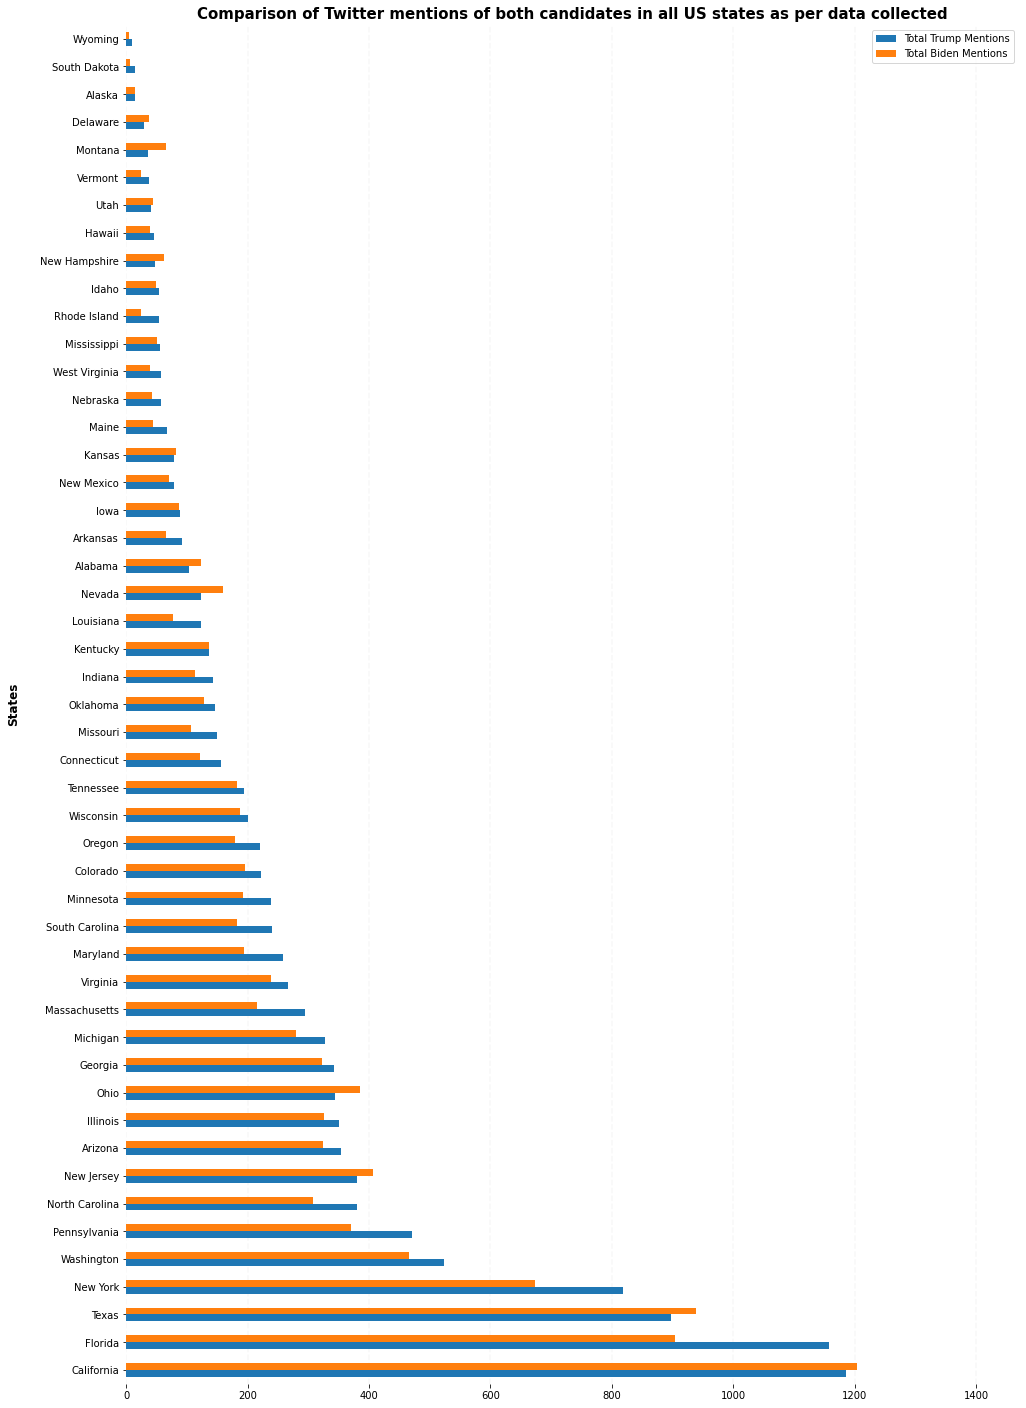

In [11]:
df = pd.merge(tweets_trump['state'].value_counts(), tweets_biden['state'].value_counts(), right_index = True, 
               left_index = True)
df = df.rename(columns = {"state_x": "Total Trump Mentions", "state_y": "Total Biden Mentions"})
ax = df.plot(kind='barh', figsize=(16, 25), zorder=2)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Replacing ticks with horizontal lines
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set y-axis label
ax.set_ylabel("States", labelpad=20, weight='bold', size=12)
ax.set_title('Comparison of Twitter mentions of both candidates in all US states as per data collected',fontweight="bold", size=15)

The above graphic shows a huge shortcoming of our analysis. Our dataset, like many other datasets is not a well distributed dataset. This means we have some states like Florida, California, Texas which have more data than others. Also, it seems that the amount of data related to Trump exceeds Biden's data by a small margin.

We proceed with our sentiment analysis now. To start off, we apply the polarity_scores() method to every tweet text in order to understand the sentiment of the tweet. The result of this method call is a dictionary showing the intensity of negative, neutral and positive sentiment in the tweet. All these three values are used to create the fourth figure which is the overall compound sentiment of the tweet. We will use this figure to judge whether the sentiment of a tweet is positive, negative or neutral.

In [12]:
tweets_trump['sentiment'] = tweets_trump['text'].apply(lambda x: sid.polarity_scores(x))
tweets_biden['sentiment'] = tweets_biden['text'].apply(lambda x: sid.polarity_scores(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
def sentimentVerdict(sentiment):
  if sentiment['compound'] >= 0.05:
    return "Positive"
  elif sentiment['compound'] <= -0.05:
    return "Negative"
  else:
    return "Neutral"

In [14]:
tweets_trump['sentiment_overall'] = tweets_trump['sentiment'].apply(lambda x: sentimentVerdict(x))
tweets_trump

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,geo,text,user,location,Subject,state,sentiment,sentiment_overall
0,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey,"{'neg': 0.181, 'neu': 0.819, 'pos': 0.0, 'comp...",Negative
1,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",Negative
2,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts,"{'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...",Positive
3,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey,"{'neg': 0.251, 'neu': 0.566, 'pos': 0.184, 'co...",Negative
4,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,"{'neg': 0.169, 'neu': 0.654, 'pos': 0.177, 'co...",Positive
...,...,...,...,...,...,...,...,...
19582,NaN,"Biden couldn’t fill a high school gym, but Do...",Glenn315,"Lincoln, NE",Donald Trump,Nebraska,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
19583,NaN,Trump shouldn't accuse doctors of profiting f...,anacfelix,"Chapel Hill, NC",Donald Trump,Delaware,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",Positive
19584,NaN,Donald Trump Jr. claims U.S. COVID deaths are ...,m_vasquez,Texas,Donald Trump,California,"{'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'comp...",Negative
19585,NaN,NEW: Closing ad from Republican Voters Agains...,kbelle1213,"Texas, USA",Donald Trump,Colorado,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'comp...",Positive


In [15]:
tweets_biden['sentiment_overall'] = tweets_biden['sentiment'].apply(lambda x: sentimentVerdict(x))
tweets_biden

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,geo,text,user,location,Subject,state,sentiment,sentiment_overall
2928,NaN,Unfortunately she along with other politicia...,gmollo1115,"Georgia, USA",Joe Biden,Georgia,"{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'comp...",Negative
2929,NaN,Let’s talk about the Hunter laptop and such. ...,mcritter61,"Houston, TX",Joe Biden,Texas,"{'neg': 0.146, 'neu': 0.758, 'pos': 0.096, 'co...",Negative
2930,NaN,Fun to think about how we learned today that ...,1kingsbay,"on the river, FL",Joe Biden,Florida,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",Positive
2931,NaN,Larry Kudlow: Joe Biden's economic plan would...,JanedgeJanis,"Texas, USA",Joe Biden,Texas,"{'neg': 0.127, 'neu': 0.873, 'pos': 0.0, 'comp...",Negative
2932,NaN,A 64-page document asserting an elaborate con...,denopotter,"Dallas, TX",Joe Biden,Texas,"{'neg': 0.159, 'neu': 0.841, 'pos': 0.0, 'comp...",Negative
...,...,...,...,...,...,...,...,...
22207,NaN,Donald Trump is just one big #COVID19 super s...,karen_brioso,"Salem, OR",Joe Biden,Oregon,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",Positive
22208,NaN,Obama was a black voted by all! He reigned...,ArcYuyu,"Las Vegas, Nevada, USA",Joe Biden,Nevada,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
22209,NaN,Tony Bobulinski Communicates A Message To Joe ...,USMCMIL03,"Texas, USA",Joe Biden,Texas,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
22210,NaN,After campaigning in 2016 to lift up the ‘forg...,JoeBiden,"Wilmington, DE",Joe Biden,Delaware,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'comp...",Negative


Now that we have classified every tweet data as either positive, negative or neutral, we can group by state and understand the general opinion of the public of that state regarding a particular candidate. This is our next course of action.

In [16]:
tweets_trump_location = tweets_trump.groupby(['state', 'sentiment_overall']).count()
tweets_trump_location = tweets_trump_location['user']
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(tweets_trump_location)

state           sentiment_overall
Alabama         Negative              37
                Neutral               39
                Positive              28
Alaska          Negative               9
                Neutral                1
                Positive               5
Arizona         Negative             137
                Neutral              116
                Positive             101
Arkansas        Negative              18
                Neutral               27
                Positive              47
California      Negative             414
                Neutral              294
                Positive             477
Colorado        Negative              92
                Neutral               57
                Positive              73
Connecticut     Negative              46
                Neutral               53
                Positive              58
Delaware        Negative              10
                Neutral                9
                Positiv

In [17]:
#tweets_biden['sentiment_overall']
def exp_graph(review,title):   
    group = review.groupby('sentiment_overall').count()
    Pol_count = list(group['sentiment'])
    Exp = list(group.index)

    group_list = list(zip(Pol_count,Exp))

    df = pd.DataFrame(group_list, columns=['Pol_count','Exp'])

    df['color'] = 'rgb(14,185,54)'
    df.loc[df.Exp == 'Netural', 'color'] = 'rgb(18,29,31)'
    df.loc[df.Exp == 'Negative', 'color'] = 'rgb(206,31,31)'
    
    go.Figure(go.Bar(x=df['Pol_count'],
                    y=df['Exp'],orientation='h',
                    marker={'color':df['color']})).update_layout(title_text=title).show()

In [18]:
exp_graph(tweets_biden,'bidden\'s Review Analysis')


In [19]:
exp_graph(tweets_trump,'Trump\'s Review Analysis')


In [20]:
tweets_biden.groupby('sentiment_overall').count()

,geo,text,user,location,Subject,state,sentiment
sentiment_overall,,,,,,,
Negative,0,3640,3640,3640,3640,3640,3640
Neutral,0,3148,3148,3148,3148,3148,3148
Positive,0,3712,3712,3712,3712,3712,3712


In [21]:
tweets_trump.groupby('sentiment_overall').count()

,geo,text,user,location,Subject,state,sentiment
sentiment_overall,,,,,,,
Negative,0,4156,4156,4156,4156,4156,4156
Neutral,0,3320,3320,3320,3320,3320,3320
Positive,0,4236,4236,4236,4236,4236,4236


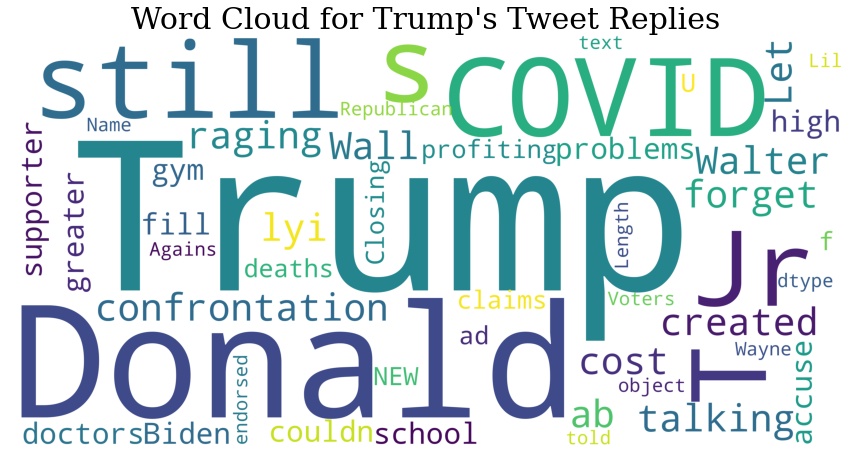

In [26]:
wordcloud(tweets_trump,'Word Cloud for Trump\'s Tweet Replies')

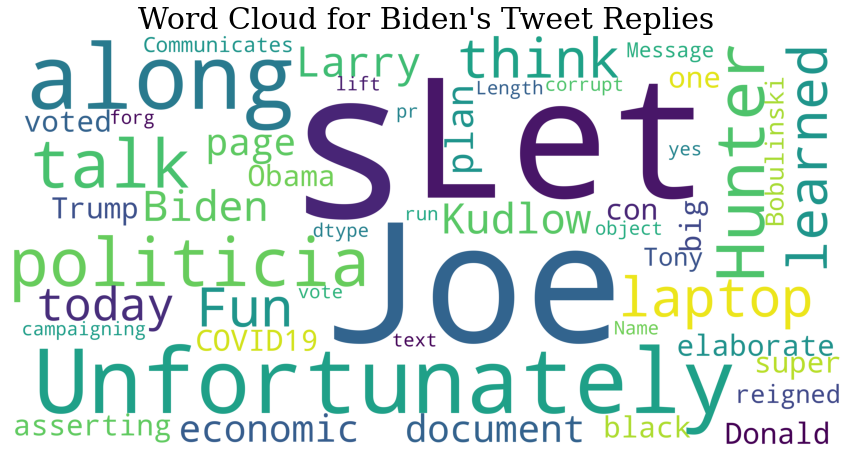

In [27]:
#wordcloud for Biden
wordcloud(tweets_biden,'Word Cloud for Biden\'s Tweet Replies')

In [28]:
tweets_biden_location = tweets_biden.groupby(['state', 'sentiment_overall']).count()
tweets_biden_location = tweets_biden_location['user']
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(tweets_biden_location)

state           sentiment_overall
Alabama         Negative              43
                Neutral               39
                Positive              42
Alaska          Negative               5
                Neutral                7
                Positive               2
Arizona         Negative             120
                Neutral               90
                Positive             114
Arkansas        Negative              15
                Neutral               25
                Positive              26
California      Negative             469
                Neutral              329
                Positive             405
Colorado        Negative              59
                Neutral               70
                Positive              66
Connecticut     Negative              46
                Neutral               41
                Positive              34
Delaware        Negative              13
                Neutral                6
                Positiv

In [29]:
tweets_location_df = pd.DataFrame({'State': [state for state in states],
                                         'Trump Positive': [0 for state in states],
                                         'Trump Negative': [0 for state in states],
                                         'Trump Neutral': [0 for state in states],
                                         'Trump Total': [0 for state in states],
                                         'Biden Positive': [0 for state in states],
                                         'Biden Negative': [0 for state in states],
                                         'Biden Neutral': [0 for state in states],
                                         'Biden Total': [0 for state in states]})
tweets_location_df.set_index('State', inplace = True)
for state in states:
  positiveTrump, negativeTrump, neutralTrump, positiveBiden, negativeBiden, neutralBiden = 0, 0, 0, 0, 0, 0
  try:
    positiveTrump = tweets_trump_location[state]['Positive']
  except:
    positiveTrump = 0
  
  try:
    negativeTrump = tweets_trump_location[state]['Negative']
  except:
    negativeTrump = 0
  
  try:
    neutralTrump = tweets_trump_location[state]['Neutral']
  except:
    neutralTrump = 0
  
  try:
    positiveBiden = tweets_biden_location[state]['Positive']
  except:
    positiveBiden = 0
  
  try:
    negativeBiden = tweets_biden_location[state]['Negative']
  except:
    negativeBiden = 0
  
  try:
    neutralBiden = tweets_biden_location[state]['Neutral']
  except:
    neutralBiden = 0

  totalTrump = positiveTrump + negativeTrump + neutralTrump
  totalBiden = positiveBiden + negativeBiden + neutralBiden

  if totalTrump == 0:
    tweets_location_df.at[state, 'Trump Positive'], tweets_location_df.at[state, 'Trump Negative'], tweets_location_df.at[state, 'Trump Neutral'] = 0,0,0
  else:
    tweets_location_df.at[state, 'Trump Positive'] = round((positiveTrump/totalTrump)*100.0)
    tweets_location_df.at[state, 'Trump Negative'] = round((negativeTrump/totalTrump)*100.0)
    tweets_location_df.at[state, 'Trump Neutral'] = round((neutralTrump/totalTrump)*100.0)
  tweets_location_df.at[state, 'Trump Total'] = totalTrump
  
  if totalBiden == 0:
    tweets_location_df.at[state, 'Biden Positive'], tweets_location_df.at[state, 'Biden Negative'], tweets_location_df.at[state, 'Biden Neutral'] = 0,0,0
  else:
    tweets_location_df.at[state, 'Biden Positive'] = round((positiveBiden/totalBiden)*100.0)
    tweets_location_df.at[state, 'Biden Negative'] = round((negativeBiden/totalBiden)*100.0)
    tweets_location_df.at[state, 'Biden Neutral'] = round((neutralBiden/totalBiden)*100.0)
  tweets_location_df.at[state, 'Biden Total'] = totalBiden
tweets_location_df



,Trump Positive,Trump Negative,Trump Neutral,Trump Total,Biden Positive,Biden Negative,Biden Neutral,Biden Total
State,,,,,,,,
Alabama,27,36,38,104,34,35,31,124
Alaska,33,60,7,15,14,36,50,14
Arizona,29,39,33,354,35,37,28,324
Arkansas,51,20,29,92,39,23,38,66
California,40,35,25,1185,34,39,27,1203
Colorado,33,41,26,222,34,30,36,195
Connecticut,37,29,34,157,28,38,34,121
Delaware,34,34,31,29,49,35,16,37
Florida,39,33,29,1158,33,33,33,904


In [30]:
tweets_location_df['Predicted Judgement'] = 'Neutral'
for index, row in tweets_location_df.iterrows():
  if row['Trump Total'] <= 15 and row['Biden Total'] <= 15:
    tweets_location_df.loc[index, 'Predicted Judgement'] = 'Insufficient Data'
  else:
    if row['Trump Positive'] > row['Biden Positive'] and (row['Trump Negative'] < row['Biden Negative'] or row['Trump Neutral'] > row['Biden Neutral']):
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Strongly Republican'
    elif row['Biden Positive'] > row['Trump Positive'] and (row['Biden Negative'] < row['Trump Negative'] or row['Biden Neutral'] > row['Trump Neutral']):
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Strongly Democratic'
    elif row['Trump Positive'] - row['Biden Positive'] > row['Biden Negative'] - row['Trump Negative']:
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Somewhat Republican'
    elif row['Biden Positive'] - row['Trump Positive'] > row['Trump Negative'] - row['Biden Negative']:
      tweets_location_df.loc[index, 'Predicted Judgement'] = 'Somewhat Democratic'
tweets_location_df = tweets_location_df.rename(columns={'Trump Positive': 'Trump Positive (in %)', 
                                                        'Trump Negative': 'Trump Negative (in %)',
                                                        'Trump Neutral': 'Trump Neutral (in %)',
                                                        'Trump Total': 'Trump Total Mentions',
                                                        'Biden Positive': 'Biden Positive (in %)',
                                                        'Biden Negative': 'Biden Negative (in %)',
                                                        'Biden Neutral': 'Biden Neutral (in %)',
                                                        'Biden Total': 'Biden Total Mentions'})
tweets_location_df

,Trump Positive (in %),Trump Negative (in %),Trump Neutral (in %),Trump Total Mentions,Biden Positive (in %),Biden Negative (in %),Biden Neutral (in %),Biden Total Mentions,Predicted Judgement
State,,,,,,,,,
Alabama,27,36,38,104,34,35,31,124,Strongly Democratic
Alaska,33,60,7,15,14,36,50,14,Insufficient Data
Arizona,29,39,33,354,35,37,28,324,Strongly Democratic
Arkansas,51,20,29,92,39,23,38,66,Strongly Republican
California,40,35,25,1185,34,39,27,1203,Strongly Republican
Colorado,33,41,26,222,34,30,36,195,Strongly Democratic
Connecticut,37,29,34,157,28,38,34,121,Strongly Republican
Delaware,34,34,31,29,49,35,16,37,Somewhat Democratic
Florida,39,33,29,1158,33,33,33,904,Somewhat Republican


In [31]:
tweets_location_df.groupby('Predicted Judgement').size()

Predicted Judgement
Insufficient Data       4
Somewhat Democratic     6
Somewhat Republican     8
Strongly Democratic    15
Strongly Republican    17
dtype: int64

From the results of my analysis, it seems as per current sentiment, the Republicans have a 21-16 lead. However, the opinion of the 13 states whose sentiment I was unable to figure out due to insufficient data can have a significant swing in fortunes for either side. The final election results will decide the success of my analysis. As we wait for Tuesday, I would encourage all Americans to go out and do cast their vote.

In [33]:
#concatinating 2 dataframes. second dataframe will be added after last row of 1st dataframe
df=pd.concat([tweets_trump,tweets_biden],axis=0)

In [34]:
df.rename(columns={"Subject":"Win"},inplace=True)

In [35]:
df

,geo,text,user,location,Win,state,sentiment,sentiment_overall
0,NaN,After the confrontation that cost Walter Wall...,wheresestela1,New Jersey,Donald Trump,New Jersey,"{'neg': 0.181, 'neu': 0.819, 'pos': 0.0, 'comp...",Negative
1,NaN,"""COVID-19 is still raging. Trump is still lyi...",TheFemaleYungin,"The Wrong Address, Texas",Donald Trump,Texas,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",Negative
2,NaN,"Donald Trump Jr.: ""Why aren't they talking ab...",KathrynTomashu1,"Northborough, MA",Donald Trump,Massachusetts,"{'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...",Positive
3,NaN,Let’s not forget who created these problems. T...,ajserino,"New Jersey, USA",Donald Trump,New Jersey,"{'neg': 0.251, 'neu': 0.566, 'pos': 0.184, 'co...",Negative
4,NaN,There is no greater supporter of Donald Trump...,SpeakBravely,"Twin Cities, Minnesota",Donald Trump,Minnesota,"{'neg': 0.169, 'neu': 0.654, 'pos': 0.177, 'co...",Positive
...,...,...,...,...,...,...,...,...
22207,NaN,Donald Trump is just one big #COVID19 super s...,karen_brioso,"Salem, OR",Joe Biden,Oregon,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",Positive
22208,NaN,Obama was a black voted by all! He reigned...,ArcYuyu,"Las Vegas, Nevada, USA",Joe Biden,Nevada,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
22209,NaN,Tony Bobulinski Communicates A Message To Joe ...,USMCMIL03,"Texas, USA",Joe Biden,Texas,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
22210,NaN,After campaigning in 2016 to lift up the ‘forg...,JoeBiden,"Wilmington, DE",Joe Biden,Delaware,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'comp...",Negative


#Data before Sample Method

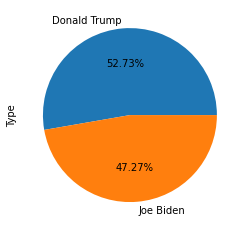

In [38]:
df.groupby("Win").size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.2f%%')

In [40]:
data=df.drop(["Win"],axis=1)
target=df['Win']

In [71]:
datax,targetx=undersampling()

Original dataset [('Donald Trump', 11712), ('Joe Biden', 10500)]
After undersampling [('Donald Trump', 10500), ('Joe Biden', 10500)]


In [43]:
dfnew=pd.concat([datax,targetx],axis=1)

In [44]:
dfnew

,geo,text,user,location,state,sentiment,sentiment_overall,Win
0,NaN,NEW VIDEO! #PleaseSaveTheseChildren If you d...,cgsteinman,"Muskegon, Michigan",Michigan,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",Negative,Donald Trump
1,NaN,Please tell me y’all aren’t taking Lil Wayne ...,Gtagrp,NJ,New Jersey,"{'neg': 0.063, 'neu': 0.704, 'pos': 0.233, 'co...",Positive,Donald Trump
2,NaN,"Donald Trump is a Liar, Thief, and the most c...",Philipm344,"Ft. Lauderdale,FL",Oregon,"{'neg': 0.379, 'neu': 0.621, 'pos': 0.0, 'comp...",Negative,Donald Trump
3,NaN,David Letterman calling Donald Trump a straig...,EyesoftheW,"Telluride,CO",North Carolina,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",Negative,Donald Trump
4,NaN,BREAKING: Donald Trump just called the proce...,Raphium,New Jersey,Texas,"{'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...",Negative,Donald Trump
...,...,...,...,...,...,...,...,...
20995,NaN,Donald Trump is just one big #COVID19 super s...,karen_brioso,"Salem, OR",Oregon,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",Positive,Joe Biden
20996,NaN,Obama was a black voted by all! He reigned...,ArcYuyu,"Las Vegas, Nevada, USA",Nevada,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,Joe Biden
20997,NaN,Tony Bobulinski Communicates A Message To Joe ...,USMCMIL03,"Texas, USA",Texas,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,Joe Biden
20998,NaN,After campaigning in 2016 to lift up the ‘forg...,JoeBiden,"Wilmington, DE",Delaware,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'comp...",Negative,Joe Biden


#Applying Polarity Using TextBlob

In [45]:
#adding polarity for tweets whose polarity >0
def polarity(review):
    if(TextBlob(review).sentiment.polarity >= 0.05):
        return TextBlob(review).sentiment.polarity
    elif(TextBlob(review).sentiment.polarity <= -0.05):
        return TextBlob(review).sentiment.polarity
    else:
        return TextBlob(review).sentiment.polarity
    

In [46]:
#add polarity column to df with polarity value for each tweet
dfnew['polarity'] = dfnew['text'].apply(polarity)

In [47]:
dfnew.head(50)

,geo,text,user,location,state,sentiment,sentiment_overall,Win,polarity
0,NaN,NEW VIDEO! #PleaseSaveTheseChildren If you d...,cgsteinman,"Muskegon, Michigan",Michigan,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",Negative,Donald Trump,0.435227
1,NaN,Please tell me y’all aren’t taking Lil Wayne ...,Gtagrp,NJ,New Jersey,"{'neg': 0.063, 'neu': 0.704, 'pos': 0.233, 'co...",Positive,Donald Trump,-0.416667
2,NaN,"Donald Trump is a Liar, Thief, and the most c...",Philipm344,"Ft. Lauderdale,FL",Oregon,"{'neg': 0.379, 'neu': 0.621, 'pos': 0.0, 'comp...",Negative,Donald Trump,0.000000
3,NaN,David Letterman calling Donald Trump a straig...,EyesoftheW,"Telluride,CO",North Carolina,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",Negative,Donald Trump,0.000000
4,NaN,BREAKING: Donald Trump just called the proce...,Raphium,New Jersey,Texas,"{'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...",Negative,Donald Trump,0.000000
5,NaN,"Ainsley Earhardt: ""People are calling it a re...",lovethydog9,"South Carolina, USA",South Carolina,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,Donald Trump,0.000000
6,NaN,"Biden couldn’t fill a high school gym, but Do...",GaryHaizlip,"Blackstone, VA",California,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,Donald Trump,-0.120000
7,NaN,NEW: Closing ad from Republican Voters Agains...,kbelle1213,"Texas, USA",Colorado,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'comp...",Positive,Donald Trump,0.068182
8,NaN,GOD BLESS THE U.S.A. AND PRESIDENT DONALD TRU...,BlancheBullshit,"Los Angeles, CA",California,"{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",Positive,Donald Trump,0.000000
9,NaN,Donald Trump is a dipshit. The presidency is ...,Fot_roca,"Baltimore, MD",Arizona,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",Negative,Donald Trump,0.000000


#Data After Sample Method

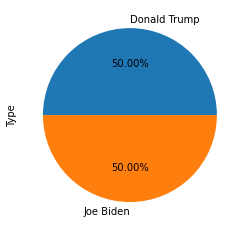

In [52]:
dfnew.groupby("Win").size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.2f%%')

#Encoding Win Column

In [80]:
lb_encoder = preprocessing.LabelEncoder().fit(dfnew['Win'])
dfnew['encoded_Win'] = lb_encoder.transform(dfnew['Win']) 

In [ ]:
Y = dfnew['encoded_Win']
X=dfnew[["polarity"]]

#Splitting Dataset

In [86]:
#splitting dataset into testing (20%) and training (80%)
x_train, x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

#SVM Model

In [89]:
pipe_svm = Pipeline([
                     ('SVM', svm.SVC(kernel='linear', C=1,gamma=0.01,random_state=0))
                    ])

In [182]:
modelsvm = pipe_svm.fit(x_train, y_train.ravel())
modelsvm.score(x_test, y_test)

0.5461904761904762

#KNN Model

In [158]:
pipe_knn = Pipeline([
    ('KNN', KNeighborsClassifier(n_neighbors = 10, weights='uniform', algorithm='auto'))
    ])

In [181]:
modelknn = pipe_knn.fit(x_train, y_train.ravel())
modelknn.score(x_test, y_test)

0.6823809523809524

#random forest model

In [160]:
pipe_rf = Pipeline([
                    ('RF',RandomForestClassifier(n_estimators=20,oob_score =True,n_jobs = -1,random_state=0))
                    ])

In [180]:
modelrf = pipe_rf.fit(x_train, y_train.ravel())
modelrf.score(x_test, y_test)

0.6778571428571428

#GaussianNB Model

In [162]:
pipe_GN = Pipeline([
                    ('GNB',GaussianNB(var_smoothing=5))
                    ])

In [179]:
modelgn = pipe_GN.fit(x_train, y_train.ravel())
modelgn.score(x_test, y_test)

0.5423809523809524

#Decision Tree Model

In [165]:
pipe_dt = Pipeline([
                    ('DT',DecisionTreeClassifier(max_depth=16,random_state=0))
                    ])

In [178]:
modeldt = pipe_dt.fit(x_train, y_train.ravel())
modeldt.score(x_test, y_test)

0.6780952380952381

#Logistic Regression Model

In [172]:
pipe_lr = Pipeline([
                    ('LR', LogisticRegression(C=20, solver='liblinear', multi_class='ovr',random_state=0,penalty='l2' ))
                    ])

In [177]:
modellr = pipe_lr.fit(x_train, y_train.ravel())
modellr.score(x_test, y_test)

0.544047619047619

#Nerual Network Model

In [174]:
pipe_nn = Pipeline([
                     ('MLP', MLPClassifier(solver='adam', hidden_layer_sizes=(40,40,20), random_state=0))
                     ])

In [176]:
modelnn = pipe_nn.fit(x_train, y_train.ravel())
modelnn.score(x_test, y_test)

0.5783333333333334

#Predict with best model

In [184]:
prediction=modelknn.predict(x_test)

In [185]:
news=list(prediction)
yy = news.count(0)
zz = news.count(1)
if yy > zz:
  print("Trump win")
else:
  print("Biden win")

Trump win
